# Лабораторная работа 3: 

## Вариант 9

In [1]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets

np.set_printoptions(precision=4)

# Task 9

a = 0
b = -2
c = -3

lx = np.pi / 2
ly = np.pi / 2

left_bound   = lambda y : np.exp(-y) * np.cos(y)
right_bound  = lambda y : 0
bottom_bound = lambda x : np.cos(x)
top_bound    = lambda x : 0

analyt_solution = lambda x, y : np.exp(-y) * np.cos(x) * np.cos(y)

# Task 10

a = -2
b = -2
c = -4

lx = np.pi / 2
ly = np.pi / 2

left_bound   = lambda y : np.exp(-y) * np.cos(y)
right_bound  = lambda y : 0
bottom_bound = lambda x : np.exp(-x) * np.cos(x)
top_bound    = lambda x : 0

analyt_solution = lambda x, y : np.exp(-x-y) * np.cos(x) * np.cos(y)

In [2]:
def make_analyt_solution(nx, ny):
        x_step = lx / (nx - 1)
        y_step = ly / (ny - 1)
        grid = np.zeros((nx, ny))
        
        for i in range(nx):
            for j in range(ny):
                grid[i, j] = analyt_solution(x_step * i, y_step * j)
        
        return grid

In [3]:
def initialize_grid(nx, ny):
    x_step = lx / (nx - 1)
    y_step = ly / (ny - 1)
    grid = np.zeros((nx, ny))

    grid[0,  :] = [left_bound(y_step * j)   for j in range(ny)]
    grid[-1, :] = [right_bound(y_step * j)  for j in range(ny)]
    grid[:,  0] = [bottom_bound(x_step * i) for i in range(nx)]
    grid[:, -1] = [top_bound(x_step * i)    for i in range(nx)]

    for i in range(1, nx - 1):
        for j in range(1, ny - 1):
            grid[i, j] = (grid[i, -1] - grid[i, 0]) * j * x_step + grid[i, 0]

    return grid

def calc_grid_val(u_up, u_left, u_down, u_right, u_mid, h_x, h_y):
    h_x2 = h_x * h_x
    h_y2 = h_y * h_y
    new_val = (
        (-1 * a * h_x * h_y2 / 2 - h_y2) * u_left +
        (     a * h_x * h_y2 / 2 - h_y2) * u_right +
        (-1 * b * h_x2 * h_y / 2 - h_x2) * u_down +
        (     b * h_x2 * h_y / 2 - h_x2) * u_up + 
        h_x2 * h_y2 * c * u_mid
    ) / (-2 * h_y2 - 2 * h_x2)

    return new_val

### Метод Либмана (простых итераций)

In [4]:
def solve_liebmann(nx, ny, *, eps, do_print=False):
    x_step = lx / (nx - 1)
    y_step = ly / (ny - 1)
    old_grid = initialize_grid(nx, ny)
    new_grid = initialize_grid(nx, ny)
    
    # Force at least one iteration
    u_max_prev = np.max(np.abs(old_grid))
    u_max = u_max_prev + eps * 2
    
    iter_no = 0
    while abs(u_max - u_max_prev) >= eps:
        iter_no += 1
        t = old_grid
        old_grid = new_grid
        new_grid = t
        
        u_max_prev = u_max
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                u_up    = old_grid[i, j + 1]
                u_down  = old_grid[i, j - 1]
                u_left  = old_grid[i - 1, j]
                u_right = old_grid[i + 1, j]
                u_mid   = old_grid[i, j]
                new_grid[i, j] = calc_grid_val(u_up, u_left, u_down, u_right, u_mid, x_step, y_step)
        u_max = np.max(new_grid[1:-1, 1:-1])

        if do_print:
            print(f"Iteration: {iter_no}, change: {u_max - u_max_prev}")

    return new_grid

Iteration: 1, change: -0.3190938230017628
Iteration: 2, change: -0.0011332288408275604
Iteration: 3, change: -0.000928495716730926
Iteration: 4, change: -0.0008509516125105865
Iteration: 5, change: -0.0008009931730121878
Iteration: 6, change: -0.0007695727307054367
Iteration: 7, change: -0.0007454518798334364
Iteration: 8, change: -0.000701703331594028
Iteration: 9, change: -0.0006632968369136849
Iteration: 10, change: -0.0005714740612208224
Iteration: 11, change: -0.0005173818509808248
Iteration: 12, change: -0.0003925624590742638
Iteration: 13, change: -0.0003379067616228193
Iteration: 14, change: -0.0002065623798916949
Iteration: 15, change: -0.00016215897577798177
Iteration: 16, change: -4.2315596949782375e-05
Iteration: 17, change: -1.1913657363749053e-05
Iteration: 18, change: 8.837473036338306e-05
Iteration: 19, change: 0.00010540406194947671
Iteration: 20, change: 0.0001846078248435301
Iteration: 21, change: 0.00019071363707434674
Iteration: 22, change: 0.00025060043080671335
I

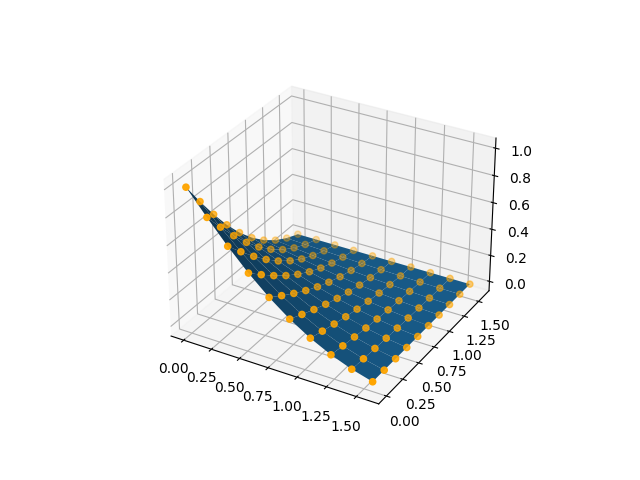

In [5]:
x_count, y_count = 10, 10
grid = solve_liebmann(x_count, y_count, eps=1e-7, do_print=True)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
real_grid = make_analyt_solution(x_count, y_count)
xs, ys = np.meshgrid(np.linspace(0, lx, x_count), np.linspace(0, ly, y_count))

ax.plot_surface(xs, ys, real_grid)
ax.scatter(xs, ys, grid, color='orange')

In [6]:
def solve_relaxation(nx, ny, *, eps, w, do_print=False):
    x_step = lx / (nx - 1)
    y_step = ly / (ny - 1)
    grid = initialize_grid(nx, ny)
    
    # Force at least one iteration
    u_max_prev = np.max(np.abs(grid))
    u_max = u_max_prev + eps * 2
    
    iter_no = 0
    while abs(u_max - u_max_prev) >= eps:
        iter_no += 1
        u_max_prev = u_max
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                u_up    = grid[i, j + 1]
                u_down  = grid[i, j - 1]
                u_left  = grid[i - 1, j]
                u_right = grid[i + 1, j]
                u_mid   = grid[i, j]
                grid[i, j] = (1 - w) * grid[i, j] + w * calc_grid_val(u_up, u_left, u_down, u_right, u_mid, x_step, y_step)
        u_max = np.max(grid[1:-1, 1:-1])

        if do_print:
            print(f"Iteration: {iter_no}, change: {u_max - u_max_prev}")

    return grid

def solve_seidel(nx, ny, *, eps, do_print=False):
    return solve_relaxation(nx, ny, eps=eps, w=1.0, do_print=do_print)

### Метод Зейделя

Iteration: 1, change: -0.3190938230017628
Iteration: 2, change: -0.0013549125616176827
Iteration: 3, change: -0.0011207007960807314
Iteration: 4, change: -0.0010344586872713668
Iteration: 5, change: -0.0010043739963515597
Iteration: 6, change: -0.0009937742666257243
Iteration: 7, change: -0.0009903741052226245
Iteration: 8, change: -0.0009639877433492705
Iteration: 9, change: -0.0008742990374432935
Iteration: 10, change: -0.0007121516901220648
Iteration: 11, change: -0.0004983573289315535
Iteration: 12, change: -0.0002649375368458662
Iteration: 13, change: -4.00420092935283e-05
Iteration: 14, change: 0.00015804587151657667
Iteration: 15, change: 0.0003207282942511158
Iteration: 16, change: 0.0004459946413820637
Iteration: 17, change: 0.0005359995713749566
Iteration: 18, change: 0.0005951790305209759
Iteration: 19, change: 0.0006288551716953084
Iteration: 20, change: 0.0006423331094436158
Iteration: 21, change: 0.0006404075177840474
Iteration: 22, change: 0.0006271553986184619
Iteration

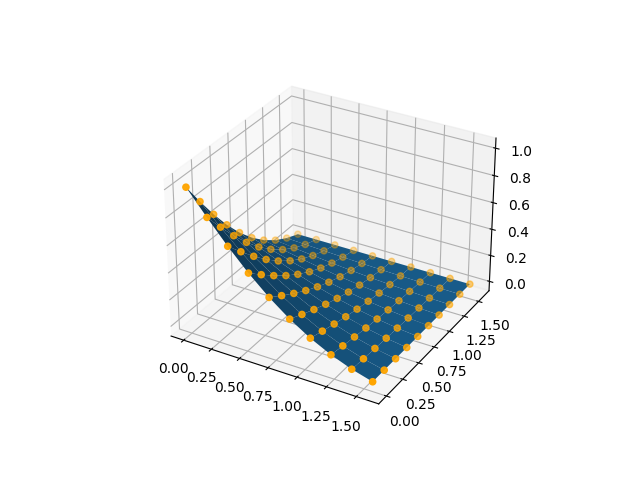

In [7]:
x_count, y_count = 10, 10
grid = solve_seidel(x_count, y_count, eps=1e-7, do_print=True)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
real_grid = make_analyt_solution(x_count, y_count)
xs, ys = np.meshgrid(np.linspace(0, lx, x_count), np.linspace(0, ly, y_count))

ax.plot_surface(xs, ys, real_grid)
ax.scatter(xs, ys, grid, color='orange')

### Метод верхних релаксаций

Iteration: 1, change: -0.32000841804308733
Iteration: 2, change: -0.0019260548875422723
Iteration: 3, change: -0.0016647237490868827
Iteration: 4, change: -0.0017418634579648984
Iteration: 5, change: -0.0018201105524126016
Iteration: 6, change: -0.0018941404721518618
Iteration: 7, change: -0.001963604114807893
Iteration: 8, change: -0.001360500103121609
Iteration: 9, change: 0.0010184818724054967
Iteration: 10, change: 0.002688087520923532
Iteration: 11, change: 0.00263949437569988
Iteration: 12, change: 0.0023732483428438034
Iteration: 13, change: 0.0020327248155976863
Iteration: 14, change: 0.0017083324697918512
Iteration: 15, change: 0.0014747888251264163
Iteration: 16, change: 0.0003650651114214254
Iteration: 17, change: 0.0006303797036462111
Iteration: 18, change: 0.0004025175998473296
Iteration: 19, change: 0.00029874189635037407
Iteration: 20, change: 0.00022421193428889818
Iteration: 21, change: 0.0001654869094745992
Iteration: 22, change: 0.00012208605401864414
Iteration: 23, 

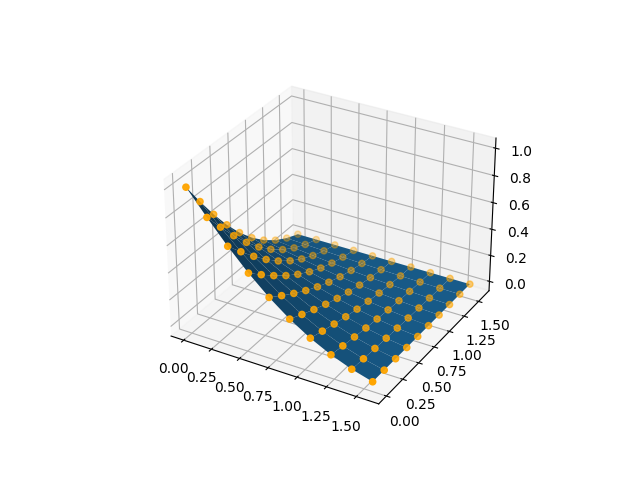

In [8]:
x_count, y_count = 10, 10
grid = solve_relaxation(x_count, y_count, eps=1e-7, w=1.5, do_print=True)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
real_grid = make_analyt_solution(x_count, y_count)
xs, ys = np.meshgrid(np.linspace(0, lx, x_count), np.linspace(0, ly, y_count))

ax.plot_surface(xs, ys, real_grid)
ax.scatter(xs, ys, grid, color='orange')